# Example: Second Harmonic Generation


## Can we emulate CW with a long-enough pulse?

Author: Luis Ledezma (ledezma@caltech.edu)

## The code

We begin by importing the modules needed, including my own. I also do some formatting. You can safely ignore all this.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
from matplotlib import cm
import colorcet as cc
from scipy import signal

#This are my libraries
import nlo 
import pulses
import materials
import waveguides

#Larger font for plots
plt.rcParams.update({'font.size': 18})

## Units
We'll work in SI base units for the most part. Here we load some constants and also create some variables for scaling units conveniently.

In [2]:
from scipy.constants import pi, c, epsilon_0
nm = 1e-9
um = 1e-6
mm = 1e-3
ps = 1e-12
fs = 1e-15
GHz = 1e9
THz = 1e12
pJ = 1e-12
fJ = 1e-15
mW = 1e-3

## Time and Frequency domain windows

### General Comments
We need to determine the FFT size $N$, as well the size of the time window $T$ and the total frequency bandwidth $F_\mathrm{BW}$. Both domain will have $N$ points, and these three parameters are related by the uncertainty relations:

$${\Delta t} {\Delta f } = \frac{1}{N}, \\
T F_{\mathrm{BW}} = N.$$

In [3]:
wl_ff = 2000*nm #Fundamental wavelength
f0_ff = c/wl_ff

#Let's set the bandwdith to LN transparency window or so
f_max = c/(800*nm)
f_min = c/(2.3*um)
BW = f_max - f_min 

#Now we can create the time and frequency arrays
NFFT = 2**13
Tmax = NFFT/BW
dt = 1/BW
t_start = -15*ps
t_stop = t_start + NFFT*dt
t = np.arange(t_start, t_stop, step=dt)
f = fftfreq(NFFT, dt)
Omega = 2*pi*f
df = f[1]-f[0]

We also need to choose a reference frequency $f_{ref}$. Our simulation is a bandpass simulation centered around this reference frequency. So, the natural frequency variable for our simulation is $$\Omega = \omega - \omega_{ref}.$$
I'll try to be consistent and use lower case variable names for absolute frequencies representing $\omega$'s, and variable names starting with an uppper case to represent $\Omega$. For, instance, the variable ```Omega``` that we just created represents $\Omega$, while in the next cell we'll define ```omega_ref``` and ```omega_abs``` which represents $\omega_{ref}$ and $\omega$.

In [4]:
#Reference frequency
f_ref = (f_min + f_max)/2
wl_ref = c/f_ref
omega_ref = 2*pi*f_ref

#Absolute frequencies and wavelengths
f_abs = f + f_ref
wl_abs = c/f_abs
omega_abs = 2*pi*f_abs
f_min = np.amin(f_abs)
f_max = np.amax(f_abs)
wl_max = c/f_min
wl_min = c/f_max

#get the frequency indexes
f0_ff_index = np.abs(f + f_ref - f0_ff).argmin()
f_ref_index = np.abs(f).argmin()

print('Fundamental wavelength = %0.1f nm' %(wl_ff/nm))
print('Fundamental frequency = %0.1f THz' %(f0_ff/THz))
print('Simulation bandwidth = %0.1f THz' %(BW/THz))
print('Time window size = %0.3f ps' %(Tmax/ps))
print('Sampling Rate = %0.3f fs' %(dt/fs))
print('Frequency Resolution = %0.3f GHz' %(df/GHz))
print('Reference wavelength = %0.1f nm' %(wl_ref/nm))
print('Reference frequency = %0.1f THz' %(f_ref/THz))
print('Minimum absolute frequency = %0.1f THz' %(f_min/THz))
print('Maximum absolute frequency = %0.1f THz' %(f_max/THz))
print('Minimum absolute wavelength = %0.1f nm' %(c/f_max/nm))
print('Maximum absolute wavelength = %0.1f um' %(c/f_min/um))
print('Array index for fundamental = %i' %(f0_ff_index))
print('Array index for reference = %i' %(f_ref_index))

Fundamental wavelength = 2000.0 nm
Fundamental frequency = 149.9 THz
Simulation bandwidth = 244.4 THz
Time window size = 33.519 ps
Sampling Rate = 4.092 fs
Frequency Resolution = 29.833 GHz
Reference wavelength = 1187.1 nm
Reference frequency = 252.5 THz
Minimum absolute frequency = 130.3 THz
Maximum absolute frequency = 374.7 THz
Minimum absolute wavelength = 800.1 nm
Maximum absolute wavelength = 2.3 um
Array index for fundamental = 4751
Array index for reference = 0


In [5]:
(3*f_max - f_min)/BW

4.066300455729167

## Material properties

I'm going to load the refractive index of lithium tantalate from my personal library named <font color=magenta> materials</font>. In that library I implement mostly Sellmeier's equations obtained from https://refractiveindex.info/ for a few common materials.

In [6]:
width = 1.85*um
hLN = 700*nm
hetch = 340*nm
wg = waveguides.waveguide(w_top=width, h_ridge=hLN, h_slab=hLN-hetch)

neff = np.zeros(wl_abs.shape)
for kw in range(wl_abs.size):
    neff[kw] = wg.neff(wl_abs[kw])
    
def n_func(wl):
    return neff

Refractive index at fundamental = 1.874


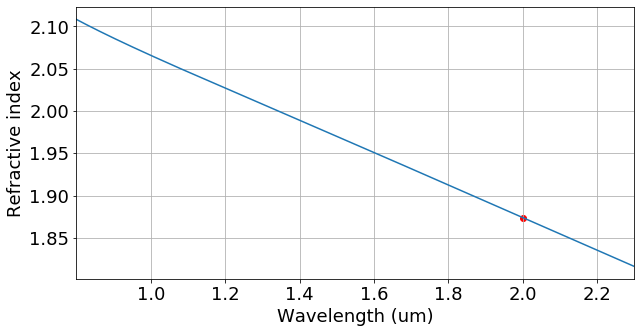

In [7]:
n = n_func(wl_abs)
nw = n[f0_ff_index]

plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(fftshift(wl_abs/um), fftshift(n))
ax1.scatter(wl_abs[f0_ff_index]/um, nw, c='r')
ax1.set_xlim([wl_min/um, wl_max/um])
ax1.set_xlabel('Wavelength (um)')
ax1.set_ylabel('Refractive index')
ax1.grid(True)

print('Refractive index at fundamental = %0.3f' %(nw))

Now we'll get the propagation constant as usual:
$$ \beta = \frac{\omega n}{c} ,$$

as well as the group velocity and GVD:
$$ 
v_g = \frac{1}{\beta_1} = \left( \frac{\partial \beta}{\partial \omega} \right)^{-1} \\
\mathrm{GVD} = \beta_2 = \frac{\partial^2 \beta}{\partial \omega^2} .
$$

We also need to get the higher order dispersion operator; this can be obtained from the propagation constant as follows:
$$D = \beta(\Omega) - \beta \big|_{\Omega=0} - \frac{\Omega}{v_{ref}}.$$

For this example we'll use $v_{ref} = v_g(2 \omega_0)$.

At this point we can also compute the GVM ($\Delta \beta^\prime $) between the fundamental signal and the moving reference frame:
$$ \Delta \beta^\prime = \frac{1}{v_{ref}} - \frac{1}{v_g(\omega_0)}, $$
and then we can compute how much a pulse at $\omega_0$ will travel in a crystal of length $L$,
$$ \tau =  L \Delta \beta^\prime. $$

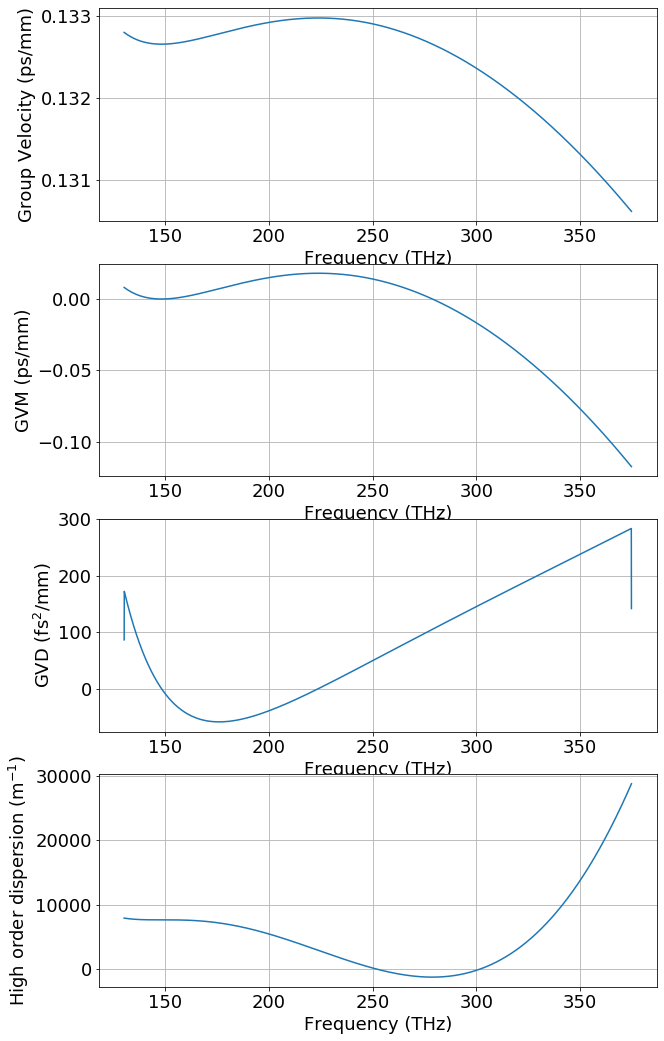

In [8]:
beta = omega_abs*n/c
beta_1 = fftshift(np.gradient(fftshift(beta), 2*pi*df))
beta_2 = fftshift(np.gradient(fftshift(beta_1), 2*pi*df))
vg = 1/beta_1

beta_ref = beta[0]
# f_v_ref = c/(700*nm)
f_v_ref = f0_ff
f_v_ref_index = np.abs(f + f_ref - f_v_ref).argmin()
# v_ref = vg[0]
# v_ref = 0.11*mm/ps
v_ref = vg[f_v_ref_index]
D = beta - beta_ref - Omega/v_ref
GVM = 1/v_ref - 1/vg

plt.rcParams['figure.figsize'] = [10, 18]
fig = plt.figure()
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(fftshift(f_abs)/THz, fftshift(vg)/(mm/ps));
ax1.set_ylabel('Group Velocity (ps/mm)'); ax1.set_xlabel('Frequency (THz)');

ax2.plot(fftshift(f_abs)/THz, fftshift(GVM)/(ps/mm));
ax2.set_ylabel('GVM (ps/mm)'); ax2.set_xlabel('Frequency (THz)');

ax3.plot(fftshift(f_abs)/THz, fftshift(beta_2)/(fs**2/mm));
ax3.set_ylabel('GVD (fs$^2$/mm)'); ax3.set_xlabel('Frequency (THz)');

ax4.plot(fftshift(f_abs)/THz, fftshift(D));
ax4.set_xlabel('Frequency (THz)'); ax4.set_ylabel('High order dispersion (m$^{-1}$)');

ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True);

## Quasi Phase Matching

In [9]:
wl_pp = 2.0*um
f1 = c/(wl_pp)
f2 = 2*f1
f1_index = np.abs(f + f_ref - f1).argmin()
f2_index = np.abs(f + f_ref - f2).argmin()

n1 = n[f1_index]
n2 = n[f2_index]

print("Poling period for second harmonic generation starting at %0.3f um = %0.3f um" %(wl_pp/um, c/f2/(n2-n1)/um))

wl_pp = 1.55*um
f1 = c/(wl_pp)
f2 = 2*f1
f1_index = np.abs(f + f_ref - f1).argmin()
f2_index = np.abs(f + f_ref - f2).argmin()

n1 = n[f1_index]
n2 = n[f2_index]

print("Poling period for second harmonic generation starting at %0.3f um = %0.3f um" %(wl_pp/um, c/f2/(n2-n1)/um))

Poling period for second harmonic generation starting at 2.000 um = 5.216 um
Poling period for second harmonic generation starting at 1.550 um = 5.244 um


In [10]:
pp = 5.216*um

N = 1
Xw = 2.6e-12
def chi2(z):
    poling = np.sign(np.cos(z*2*pi/pp))
    return poling*Xw*omega_abs/(2*4*N)

## Nonlinear  Component
Now we create a nonlinear component based on this refractive index and propagation constant. This nonlinear component implements a method for propagation using the NEE.

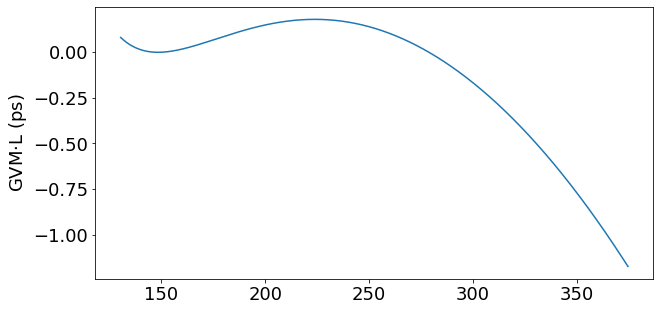

In [11]:
L = 10*mm
Alpha = 0.1     # attentuation coefficient (dB/cm)
alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m
crystal = nlo.nonlinear_element(L, n_func=n_func, chi2=chi2, alpha=alpha)

#Let's also check again the GVM now that we have the crystal length
plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(fftshift(f_abs)/THz, fftshift(GVM*L)/(ps));
ax1.set_ylabel('GVM$\cdot$L (ps)'); ax2.set_xlabel('Frequency (THz)');

## Input pulse creation

We can find the peak value of the pulse from the intensity
$$
E_p = \sqrt{\frac{2 I}{n_\omega c \epsilon_0}}.
$$

The reference frequency $\omega_{ref}$ is mapped to zero in $\Omega$. So, to generate a pulse at frequency $\omega_0$ we need to modulate it:
$$
p(t) e^{j (\omega_0 - \omega_{ref}) t} = p(t) e^{j \Omega_0 t}.
$$

Let's now generate the pulse, add a bit of noise to it, and plot it to verify it is at the right frequency and looks like we expect it to look.

Here I introduce a class named ```pulse```, the goal is to pack everything relevant to the pulse into a single object, just like we did with ```nonlinear_element```. I also have a bunch of convenience methods associated with ```pulse``` for things like plotting, calculating FWHM, energy, etc.

Pulse Energy = 1000.6 fJ
Peak Power = 188.0 mW


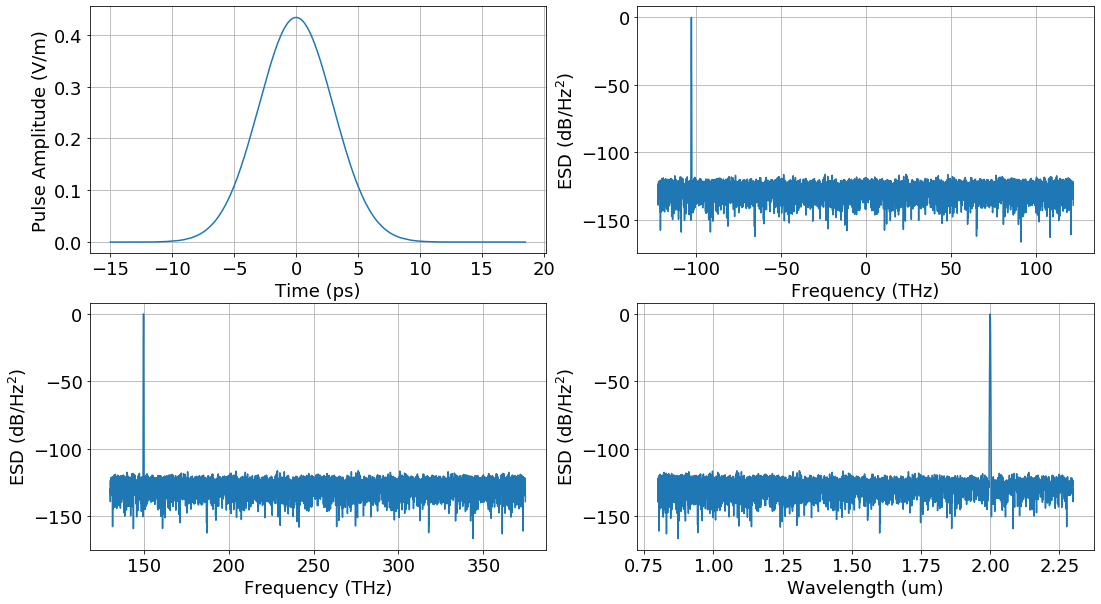

In [12]:
#Frequency offset from reference:
Omega_0 = 2*pi*(f0_ff - f_ref)

#Pulse width:
# tau = 50*fs
tau = 5*ps

#Peak value:
Energy = 1000*fJ
Ppeak = np.sqrt((0.94*Energy/tau))

#Noise floor
N_dB = 100
noise = Ppeak * 10**(-N_dB/20) * np.random.normal(size=NFFT)

#Pulse creation
x = Ppeak*np.exp(-2*np.log(2)*(t/tau)**2)*np.exp(1j*Omega_0*t)
x = x + noise
pulse = pulses.pulse(t, x, wl_ref)
print('Pulse Energy = %0.1f fJ' %(pulse.energy_td()/fJ))
print('Peak Power = %0.1f mW' %(np.amax( abs(pulse.a)**2 )/mW ))

plt.rcParams['figure.figsize'] = [18, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1 = pulse.plot_mag(ax=ax1, t_unit='ps'); ax1.set_ylabel('Pulse Amplitude (V/m)')
ax2 = pulse.plot_ESD_dB(ax=ax2, label='ESD (dB/Hz$^2$)', f_unit = 'THz')
ax3 = pulse.plot_ESD_dB_absfreq(ax=ax3, label='ESD (dB/Hz$^2$)', f_unit = 'THz')
ax4 = pulse.plot_ESD_dB_vs_wavelength(ax=ax4, label='ESD (dB/Hz$^2$)', wl_unit='um');

## Single pass

Finally, we can run the simulation. The method ```propagate_NEE``` takes a pulse object, a step size, and a reference velocity for the moving frame and outputs a pulse and it's evolution along the crystal.

In [13]:
h = pp/20 #Step size
[out_pulse, pulse_evol_full] = crystal.propagate_NEE_fd(pulse, h, v_ref=v_ref, Nup=4, method='waveguide')

Crystal length = 10.00 mm
Step size = 0.26 um
Number of steps = 38343
Using method = waveguide
Completed propagation along 0.5 mm (16.7 s)
Completed propagation along 1.0 mm (14.1 s)
Completed propagation along 1.5 mm (14.3 s)
Completed propagation along 2.0 mm (14.2 s)
Completed propagation along 2.5 mm (14.0 s)
Completed propagation along 3.0 mm (13.8 s)
Completed propagation along 3.5 mm (13.9 s)
Completed propagation along 4.0 mm (13.8 s)
Completed propagation along 4.5 mm (13.3 s)
Completed propagation along 5.0 mm (13.1 s)
Completed propagation along 5.5 mm (13.6 s)
Completed propagation along 6.0 mm (13.0 s)
Completed propagation along 6.5 mm (13.0 s)
Completed propagation along 7.0 mm (13.8 s)
Completed propagation along 7.5 mm (13.0 s)
Completed propagation along 8.0 mm (13.2 s)
Completed propagation along 8.5 mm (13.1 s)
Completed propagation along 9.0 mm (13.0 s)
Completed propagation along 9.5 mm (13.0 s)
Completed propagation along 10.0 mm (12.9 s)
Total time = 274.3 s


In [14]:
print('Input pulse energy = %0.3f fJ' %(pulse.energy_td()/fJ))
print('Output pulse energy = %0.3f fJ' %(pulses.energy_td(t, out_pulse)/fJ))

Input pulse energy = 1000.599 fJ
Output pulse energy = 977.789 fJ


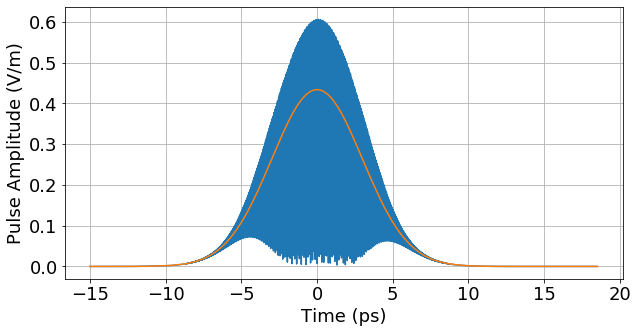

In [15]:
plt.rcParams['figure.figsize'] = [10, 5]
ax1 = pulses.plot_mag(t, out_pulse)
ax1 = pulse.plot_mag(ax=ax1)
# ax1.set_xlim(-2,0.5)
# ax1.set_ylim(0,2e8)
ax1.set_ylabel('Pulse Amplitude (V/m)')
ax1.set_xlabel('Time (ps)');

Text(0, 0.5, '')

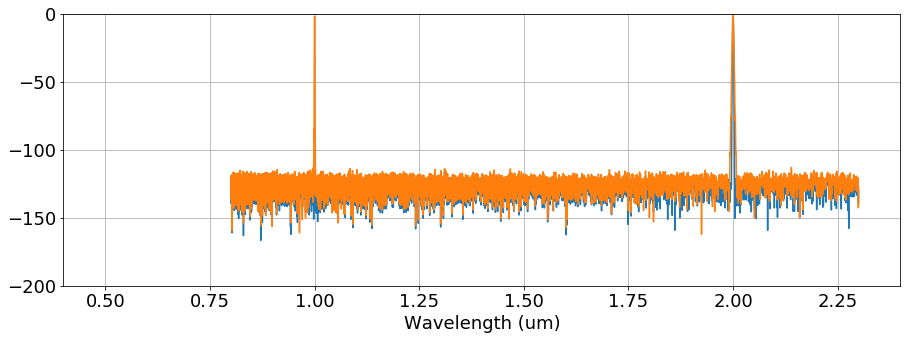

In [16]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)
pulse.plot_ESD_dB_vs_wavelength(ax=ax1)
pulses.plot_ESD_dB_vs_wavelength(t, out_pulse, f_ref, ax=ax1)
ax1.set_xlim([0.4, 2.4])
ax1.set_ylim([-80,0])
ax1.set_ylim([-200,0])
ax1.set_ylabel('')

We can also look at the evolution of the pulse along the crystal. Here it also clear that the input pulse travels while it creates a faint second harmonic that is stationary in the simulation frame. 

## Pulse evolution along the crystal

In [29]:
#Downsample evolution for plotting
Ndown = 100
pulse_evol = pulse_evol_full[::,::Ndown]
Nsteps = pulse_evol.shape[1]-1

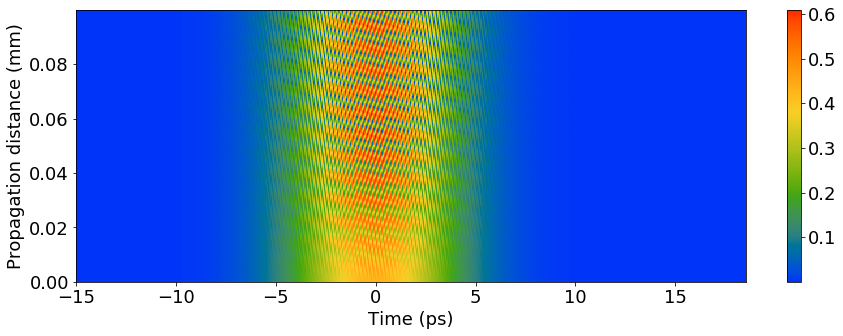

In [30]:
plt.rcParams['figure.figsize'] = [15, 5]
Nsteps = pulse_evol.shape[1]-1
X,Y = np.meshgrid(t/ps, np.arange(Nsteps+1)*h*1e3)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(X, Y, (np.transpose(np.abs(pulse_evol))), cmap = cc.cm["rainbow"])
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Propagation distance (mm)')
# ax.set_ylim([0,5])
# ax.set_xlim([-2,0.5])
plt.colorbar(im, ax=ax);

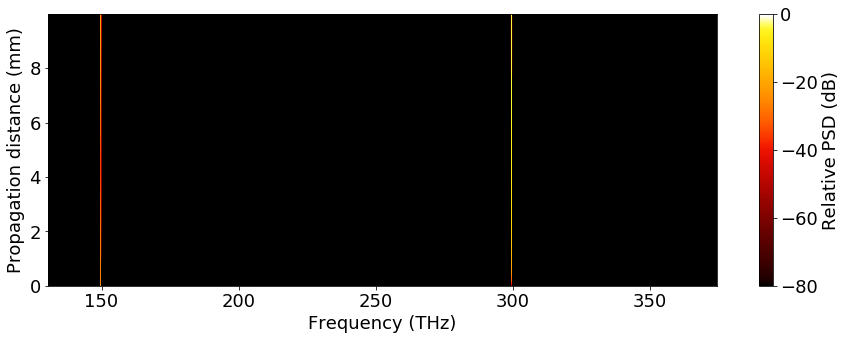

In [31]:
A_evol = np.zeros((t.size, Nsteps+1))

for k in range(Nsteps+1):
    x = pulse_evol[:,k]
    _ , Aesd = pulses.get_esd(t, x)
    A_evol[:,k] = 10*np.log10(Aesd)

A_evol = A_evol - np.amax(A_evol)
A_evol = fftshift(A_evol, axes=0)

plt.rcParams['figure.figsize'] = [15, 5]

X,Y = np.meshgrid(fftshift(f+f_ref)*1e-12, np.arange(Nsteps+1)*h*Ndown/mm)
plt.figure()
plt.pcolormesh(X, Y, (np.transpose(A_evol)), cmap = cc.cm["fire"], vmin=-80, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Frequency (THz)')
plt.ylabel('Propagation distance (mm)');

### Let's check the energy progression along the crystal

Text(0, 0.5, 'Pulse Amplitude (V/m)')

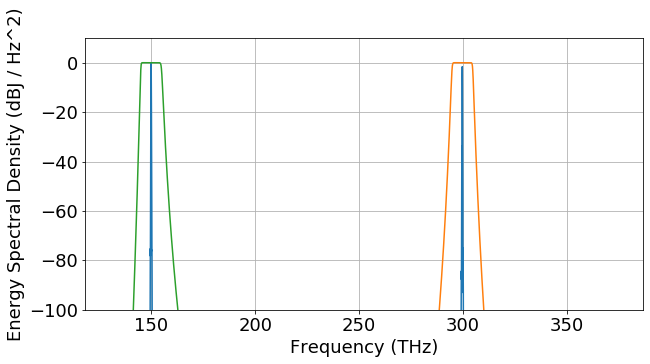

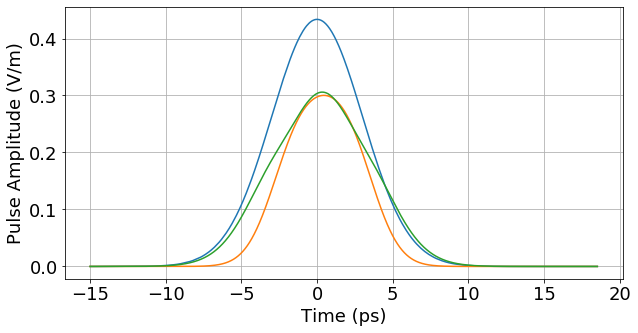

In [32]:
filter_bw = 10*THz

f1 = (f0_ff - filter_bw/2 - f_min)/(f_max-f_min)
f2 = (f0_ff + filter_bw/2 - f_min)/(f_max-f_min)
sos = signal.butter(15, [f1, f2], 'bandpass', output='sos')
_, h_ff = signal.sosfreqz(sos, worN=NFFT)

f1 = (2*f0_ff - filter_bw/2 - f_min)/(f_max-f_min)
f2 = (2*f0_ff + filter_bw/2 - f_min)/(f_max-f_min)
sos = signal.butter(15, [f1, f2], 'bandpass', output='sos')
_, h_sh = signal.sosfreqz(sos, worN=NFFT)

out_sh = ifft(fft(out_pulse)*fftshift(h_sh))
out_ff = ifft(fft(out_pulse)*fftshift(h_ff))

plt.rcParams['figure.figsize'] = [10, 5]
ax1 = pulses.plot_ESD_dB_absfreq(t, out_pulse, f_ref)
ax1.plot(fftshift(f+f_ref)*1e-12, 20*np.log10(abs(h_sh + 1e-20)));
ax1.plot(fftshift(f+f_ref)*1e-12, 20*np.log10(abs(h_ff + 1e-20)))
ax1.set_ylim([-100,10])
# ax1.set_xlim([150, 500])

plt.rcParams['figure.figsize'] = [10, 5]
ax1 = pulse.plot_mag()
ax1 = pulses.plot_mag(t, out_sh, ax=ax1)
ax1 = pulses.plot_mag(t, out_ff, ax=ax1)
ax1.set_ylabel('Pulse Amplitude (V/m)')
# ax1.set_xlim([-1, 1])

In [33]:
pulses.FWHM(t, np.abs(out_ff), prominence=np.abs(out_ff)/50)/ps

array([5.27888487])

In [34]:
pulses.FWHM(t, np.abs(out_sh), prominence=np.abs(out_sh)/50)/ps

array([4.8221352])

In [35]:
h_ff_tiled = np.tile(h_ff, (pulse_evol.shape[1],1)).transpose()
out_ff = ifft(fft(pulse_evol, axis=0)*fftshift(h_ff_tiled, axes=0), axis=0)
pwr_ff = abs(out_ff)**2
energy_ff = np.sum(pwr_ff, axis=0)*dt

h_sh_tiled = np.tile(h_sh, (pulse_evol.shape[1],1)).transpose()
out_sh = ifft(fft(pulse_evol, axis=0)*fftshift(h_sh_tiled, axes=0), axis=0)
pwr_sh = abs(out_sh)**2
energy_sh = np.sum(pwr_sh, axis=0)*dt

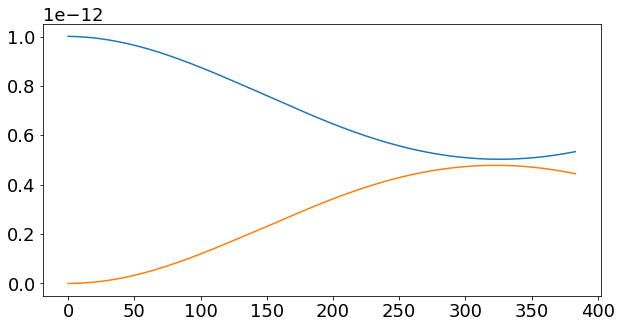

In [42]:
plt.plot(energy_ff)
plt.plot(energy_sh)

Instantaneous Efficiency

Equation (5.77) Weiner

In [36]:
z = np.linspace(0, L, Nsteps+1)

z = 2.6 mm


(0, 2000)

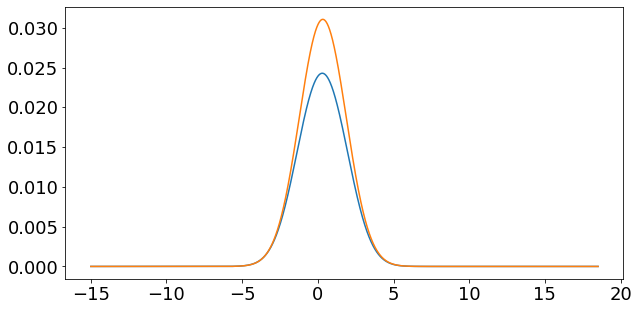

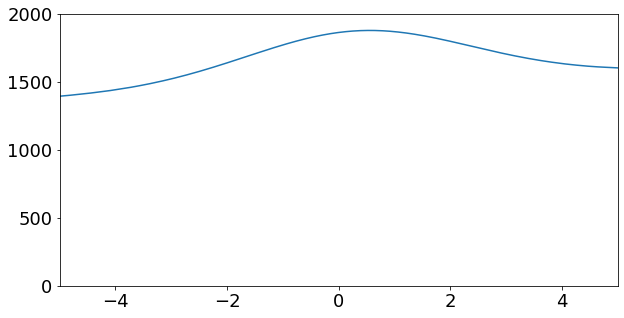

In [38]:
#Constant z
kz = 100
print('z = %0.1f mm' %(z[kz]/mm))
plt.plot(t/ps, pwr_ff[:,kz]**2)
plt.plot(t/ps, pwr_sh[:,kz])

plt.figure()
efficiency = pwr_sh[:, kz]/( pwr_ff[:, kz]**2 * (z[kz]/(10*mm))**2 ) * 100
plt.plot(t/ps, efficiency)
plt.xlim([-5, 5])
plt.ylim([0, 2000])

t = 0.000 ps


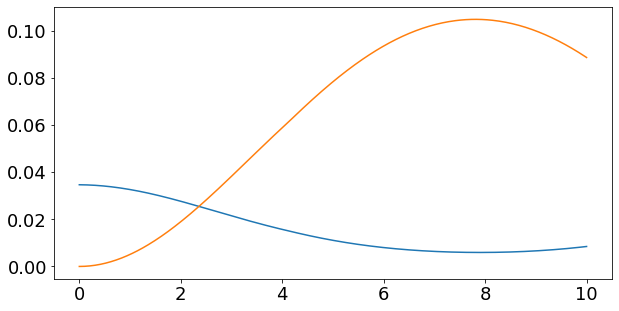

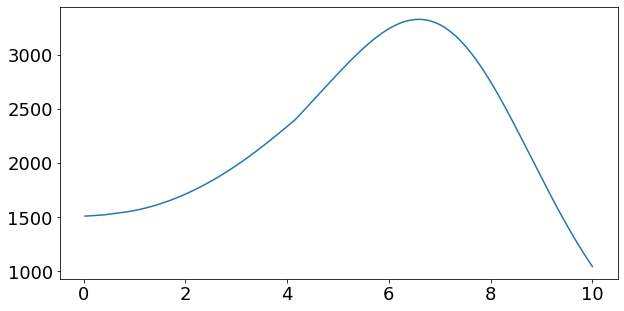

In [39]:
#Constant t
kt =  3666
print('t = %0.3f ps' %(t[kt]/ps))
plt.plot(z/mm, pwr_ff[kt,:]**2)
plt.plot(z/mm, pwr_sh[kt,:])

plt.figure()
efficiency = pwr_sh[kt,1:]/( pwr_ff[kt,1:]**2 * (z[1:]/(10*mm) )**2 ) * 100
plt.plot(z[1:]/mm, efficiency)
# plt.ylim([0, 5000])

Using Fluences

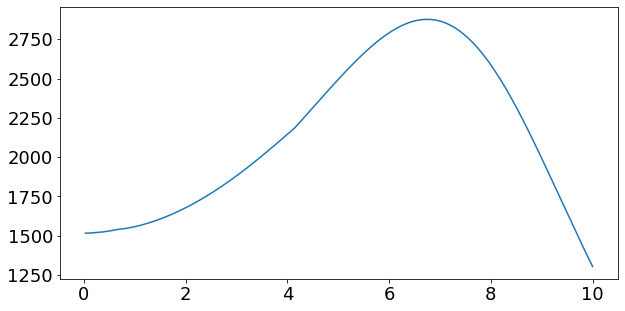

In [40]:
kz = 1
fluence_2w = np.sum(pwr_sh, axis=0)*dt 
integral_w = np.sum(pwr_ff**2, axis=0)*dt 

gamma2 = fluence_2w[1:] / (integral_w[1:] * (z[1:]/1e-2)**2) * 100

plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(z[1:]/mm, gamma2)

# <center> END OF DOCUMENT </center>

In [ ]:
# #Formatting stuff
# from IPython.core.display import HTML
# def css_styling():
#     styles = open("custom.css", "r").read()
#     return HTML(styles)
# css_styling()

### Software Versions

In [ ]:
# %load_ext version_information
# %version_information scipy, numpy, matplotlib